In [131]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import deep_inference_inference as dii
import glob
# Set styles
sns.set(style = "white")

In [132]:
def run_bayesian_t_tests_single_exp(experiment = [0], 
                                    experiment_meta_data = [],
                                    p_val = 0.05):
    
    # Process meta dat
    n_perturb = len(np.unique(experiment_meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(experiment_meta_data.iloc[:, 1])) - 1
    
    
    base_post_samples = experiment[1][0]
    compare_post_samples = experiment[1][1:]
    diff_samples = np.zeros((compare_post_samples.shape))
    #print('diff_samples shape: ', diff_samples.shape)
    p_vals = []
    p_vals_crit = []
    
    param_perturb_array = np.zeros((n_params * n_perturb, 2))
    
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            diff_samples[i] = (base_post_samples - compare_post_samples[i]) * np.sign((base_post_samples[0] - experiment[0][i]) + 1e-7)
            #print('diff_samples: ')
            #print(diff_samples[i])
            p_vals.append(((diff_samples[i] < 0).mean(axis = 0)))
            p_vals_crit.append((p_vals[i] < p_val).astype(int))
            
            param_perturb_array[i, 0] = param
            param_perturb_array[i, 1] = perturb
            i += 1
        
    return diff_samples, np.array(p_vals), np.array(p_vals_crit), param_perturb_array

def run_bayesian_t_tests_single_exp_fcn(experiment = [],
                                        experiment_meta_data = [],
                                        p_val = 0.05,
                                        n_post_samples = 10000):
    # Process meta dat
    n_perturb = len(np.unique(experiment_meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(experiment_meta_data.iloc[:, 1])) - 1
    
    
    base_post_estimates = experiment[1][0, :n_params]
    base_post_variances = experiment[1][0, n_params:]
    compare_post_estimates = experiment[1][1:, :n_params]
    compare_post_variances = experiment[1][1:, n_params:]
    
    base_post_samples = np.random.normal(loc = base_post_estimates, 
                                         scale = np.sqrt(base_post_variances), 
                                         size = (n_post_samples, n_params))
    
    diff_samples = np.zeros((n_perturb * n_params, n_post_samples, n_params))
    p_vals = []
    p_vals_crit = []
    
    param_perturb_array = np.zeros((n_params * n_perturb, 2))
    
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            compare_post_samples = np.random.normal(loc = compare_post_estimates[i], 
                                                    scale = np.sqrt(compare_post_variances[i]),
                                                    size = (n_post_samples, n_params))
            
            diff_samples[i] = (base_post_samples - compare_post_samples[i]) * np.sign((base_post_estimates[0] - experiment[0][i]) + 1e-7)
            p_vals.append(((diff_samples[i] < 0).mean(axis = 0)))
            p_vals_crit.append((p_vals[i] < p_val).astype(int))
            
            param_perturb_array[i, 0] = param
            param_perturb_array[i, 1] = perturb
            i += 1
        
    return diff_samples, np.array(p_vals), np.array(p_vals_crit), param_perturb_array


def bayesian_t_test_global(file_list = '',
                           meta_data = [0],
                           kind = 'posterior_samples'# 'posterior_samples', 'fcn'
                          ): 
    n_files = len(file_list)
    
    if n_files == 0:
        print('Supply files....')
        return
    if n_files == 1:
        # Process file
        tmp_dat = pickle.load(open(file_list[0], 'rb'))
        
        out, p_vals, p_vals_crit, meta = run_bayesian_t_tests(experiment = tmp_dat[2],
                                                              experiment_meta_data = meta_data)
        return np.concatenate([p_vals_crit, meta])
    
    if n_files > 1:
        out = [0 for i in range(n_files)]
        p_vals = [0 for i in range(n_files)]
        p_vals_crit = [0 for i in range(n_files)]
        meta = [0 for i in range(n_files)]
        return_dat = [0 for i in range(n_files)]
        cnt = 0
        for file_ in file_list:
            
            # Process file
            tmp_dat = pickle.load(open(file_, 'rb'))
            tmp_dat = [tmp_dat[0], tmp_dat[2]]
            
            if kind == 'posterior_samples':
                out[cnt], p_vals[cnt], p_vals_crit[cnt], meta[cnt] = run_bayesian_t_tests_single_exp(experiment = tmp_dat,
                                                                                                     experiment_meta_data = meta_data)

            if kind == 'fcn':
                 out[cnt], p_vals[cnt], p_vals_crit[cnt], meta[cnt] = run_bayesian_t_tests_single_exp_fcn(experiment = tmp_dat,
                                                                                                          experiment_meta_data = meta_data)
            #print(p_vals[cnt].shape)
            #print(meta[cnt].shape)
            #print(p_vals_crit[cnt].shape)
            return_dat[cnt] = np.concatenate([p_vals_crit[cnt], meta[cnt]], axis = 1)
            
            print(file_)
            cnt += 1
            
        #out = np.concatenate([out], axis = 0)
        #p_vals = np.concatenate([p_vals], axis = 0)
        #p_vals_crit = np.concatenate([p_vals_crit], axis = 0)
        #meta = np.concatenate([meta], axis = 0)
        #print(meta.shape)
        #print(p_vals_crit.shape)
        
        return np.concatenate(return_dat, axis = 0)
    
def get_detection_ratios(t_test_results = [0]):
    n_params = len(np.unique(t_test_results[:, -2]))
    n_perturb = len(np.unique(t_test_results[:, -1]))
    n_exp_levels = n_params * n_perturb
    n_exp_by_level = out.shape[0] / n_exp_levels

    detection_ratios = np.zeros((n_perturb, n_params))

    for i in range(n_params):
        for j in range(n_perturb):
            detection_ratios[j, i] = np.sum(t_test_results[(t_test_results[:, -1] == j) & \
                                                           (t_test_results[:, -2] == i), i]) / n_exp_by_level
    return detection_ratios

# SUPPORT FUNCTIONS GRAPHS
def detection_rate_plots(ax_titles = ['v', 'a', 'w', 'ndt'], 
                         title = 'Effect detection: Bayesian T-test',
                         data = [],
                         cols = 3):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].bar(x = ['0.05', '0.1', '0.2'], height = data[:, i])
        ax[row_tmp, col_tmp].set_xlabel('Perturbation Levels', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel('Detection Probability', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_title(ax_titles[i], 
                                       fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)

    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    return plt.show()

In [140]:
# Initializations
sample_sizes = [100, 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/kde/ddm/method_comparison/'
file_base_name = file_folder + 'post_samp_perturbation_experiment_nexp_1_n_'
detection_ratio_list = []

# Load meta_data file (assumed to be same across all experiment datasets)
meta_data = pickle.load(open(glob.glob(file_folder + 'base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]

# Get detection ratios for all experiments
for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out = bayesian_t_test_global(file_list = files_,
                             meta_data = meta_data)
    detection_ratio_list.append(get_detection_ratios(out))


/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_1005995f2de-f531-11e9-9511-190bbaa5deb4.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_10d6cd9920-f534-11e9-b65c-ed8601ef79a0.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_1165b2cde0-f535-11e9-b178-0d50847f46ce.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_12edfb8a06-f536-11e9-a50c-a78afc335ecf.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_13847f644a-f526-11e9-bd96-1971422ce3ef.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_144ea67038-f536-11e9-8e14-8dc943b9a5de.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_6120746a1a-f538-11e9-9e8c-d55f52ad39b5.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_620c74d3e2-f538-11e9-9f5c-af63823c8933.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_6324eeb46-f526-11e9-a4b8-770b1d2724a8.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_63de8df612-f527-11e9-82a6-ab08925b5ee1.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_6415ded7fc-f538-11e9-a624-fb96b603c753.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_100_65dfdb6310-f527-11e9-bd44-8bf6020c0c26.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_2007f0d96c-f536-11e9-a4ae-73f6d00854ed.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_2149fde1ec-f536-11e9-afd1-7bac5b0d979d.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_224a597c46-f536-11e9-b7ee-dd37e7330257.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_2343e9809a-f536-11e9-bebe-253f201f9945.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_2405eef40-f532-11e9-939e-7dde2de9fdc7.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_24705a55e6-f536-11e9-93be-9fe0e4c05534.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_2

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_70cb338894-f53a-11e9-8a2d-b5abf038f119.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_71e6a0e144-f53a-11e9-b776-8f9e5feccced.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_72f1a1e264-f53a-11e9-9ceb-0f4cf64a4659.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_7309cd0828-f53b-11e9-9f67-4bd0e64c4194.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_740e822b32-f53b-11e9-b1f3-e594984774ff.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_250_75999ea6f2-f539-11e9-8c9e-25e050b07ed2.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_309292de7c-f53f-11e9-92e9-4592ad994227.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_31c9e5c896-f542-11e9-aa02-13b0b8e4d6de.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_32c6375f5e-f540-11e9-aca4-e35bfd7c5095.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_3344159466-f543-11e9-bed4-b7ebcd375a2d.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_34574c069c-f542-11e9-a34d-d514f7ee92f2.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_356011db70-f543-11e9-be1e-4fc4fc911fdd.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_805cb72394-f54e-11e9-8a23-396fea26a453.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_81296631e2-f54e-11e9-8687-2f5e33d12864.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_827435a61c-f54e-11e9-bee8-9dbe0a7af1fe.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_833a5254b8-f54e-11e9-b8f5-bbab9b1be4c4.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_84e8fe1dbc-f54e-11e9-82f2-0559b155e019.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_500_85bfd2ade4-f54a-11e9-864f-dbedd08ea944.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_390bc8db64-f560-11e9-ad92-f9a8a4f2ba8f.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_40c119e0a6-f55d-11e9-98f6-591a2145e134.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_4196f81178-f560-11e9-bd56-23b9ad573231.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_42c7630232-f55b-11e9-8504-2b49d183a33e.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_43d77a6c1e-f560-11e9-be19-75b96c964411.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_44f7ade84e-f55b-11e9-b2a0-255849ca24b2.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nex

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_90273a7666-f568-11e9-a6df-4174ba12b683.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_9191454d8-f556-11e9-ac58-8ba05c0a02d5.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_91c5320926-f570-11e9-b4af-252ea75485bf.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_9257ca120c-f570-11e9-a315-7fab6e7c3f7f.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_93bf0c8490-f570-11e9-a738-85154c2e3669.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_1000_9436d2264a-f569-11e9-bba9-95b97ae9dceb.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_2000_507e95cfe6-f595-11e9-a565-474e6d94f111.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_2000_51628ef7f4-f591-11e9-8e13-f79b3fdf37f4.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_2000_5292879ac4-f591-11e9-b9e9-e3a895b14140.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_2000_532109dbd4-f599-11e9-b947-430630a3cb05.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_2000_53f8d67ce-f57b-11e9-86b5-7b90a6bea610.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_2000_54f98cd80e-f598-11e9-9b06-65e03f378a39.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_100e7913336-f5ff-11e9-acc3-0546db8de01d.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_10db1d22a2-f5b6-11e9-9934-ef3ba48c22d6.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_111d3c14f4-f5b2-11e9-9027-2f7e1c9dc8af.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_1251dae472-f5b4-11e9-8301-e304c0f020c1.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_1314846d0-f5c5-11e9-8174-0dc810566618.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_13a9c7efe2-f5c1-11e9-89d8-4bc532aec0ca.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nex

/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_60a53fe374-f5dc-11e9-ae69-e13f0d43ec6b.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_61d10cdfca-f5d7-11e9-a7b9-8b39baff187b.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_6257e6835a-f5d5-11e9-8e15-4f9e6c8c8010.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_63f8614154-f5d4-11e9-b140-85722610dc5d.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_64dbfbcdb6-f5d6-11e9-9d2d-27af9fb09aef.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nexp_1_n_3000_65d126cac2-f5df-11e9-9a94-1f7890e20116.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/post_samp_perturbation_experiment_nex

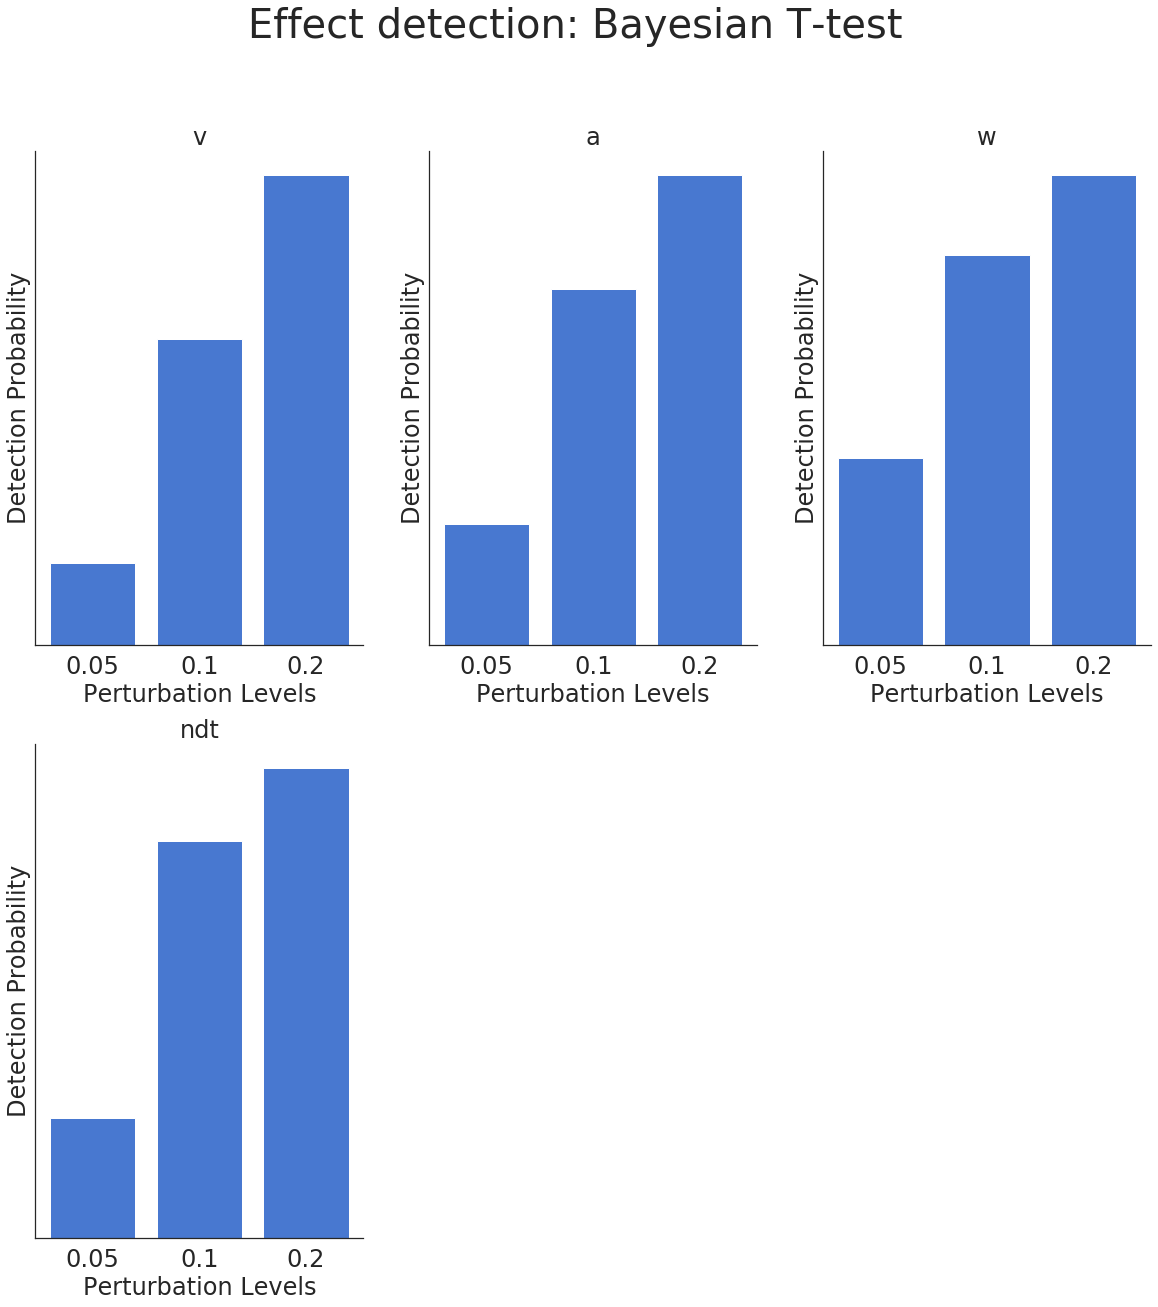

In [141]:
# n = 100
detection_rate_plots(data = detection_ratio_list[0])

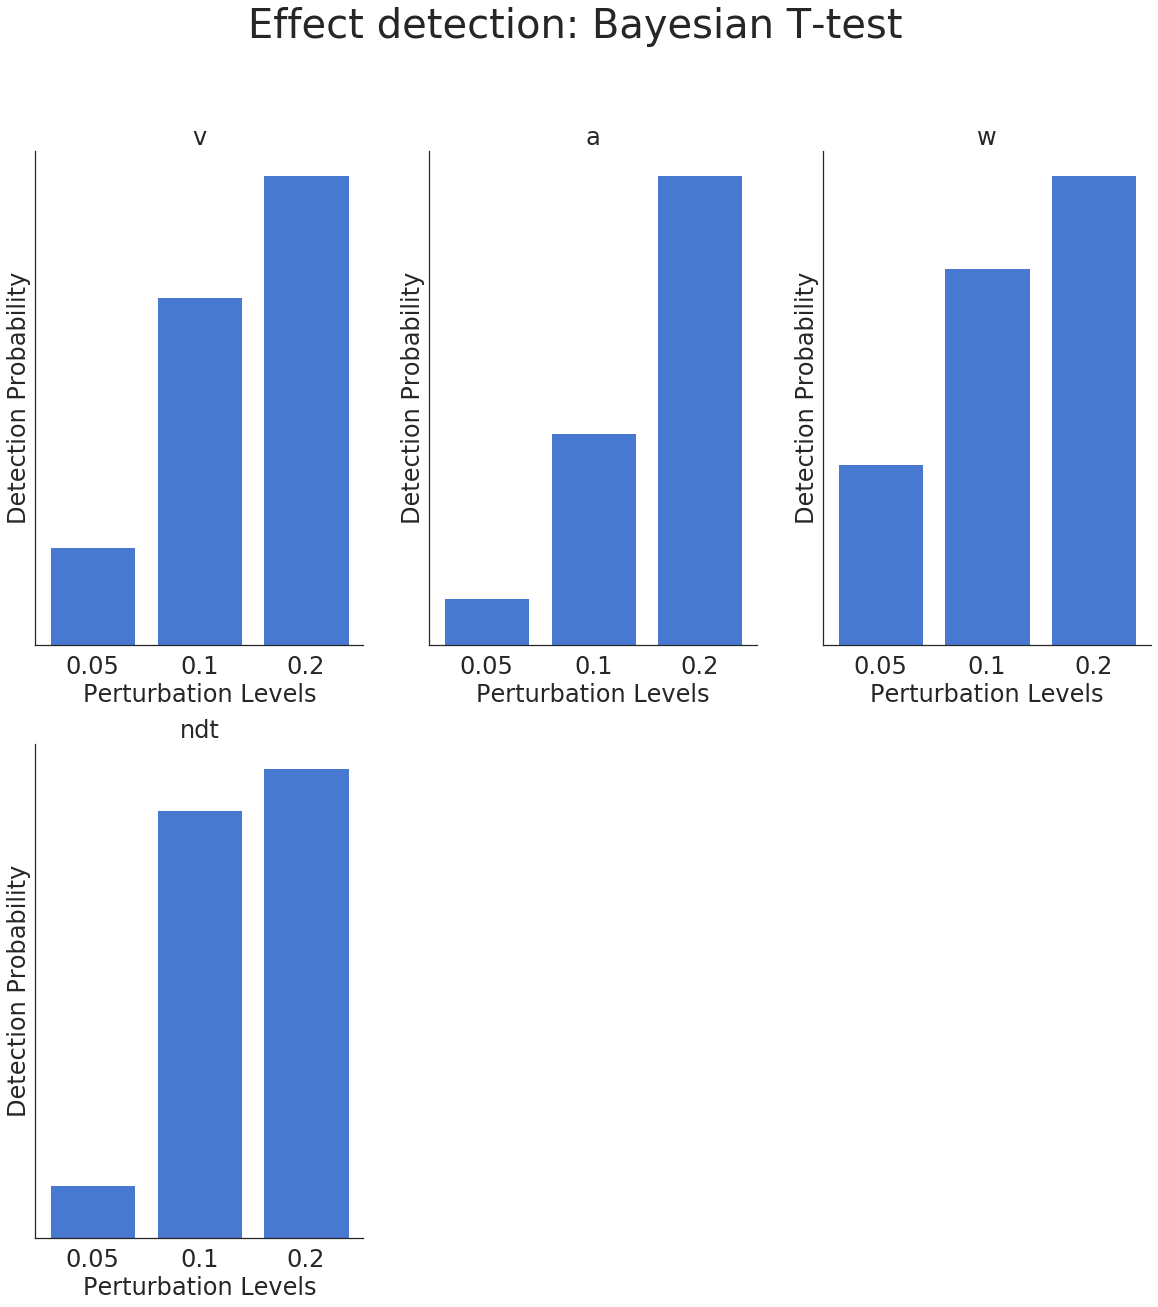

In [142]:
# n = 250
detection_rate_plots(data = detection_ratio_list[1])

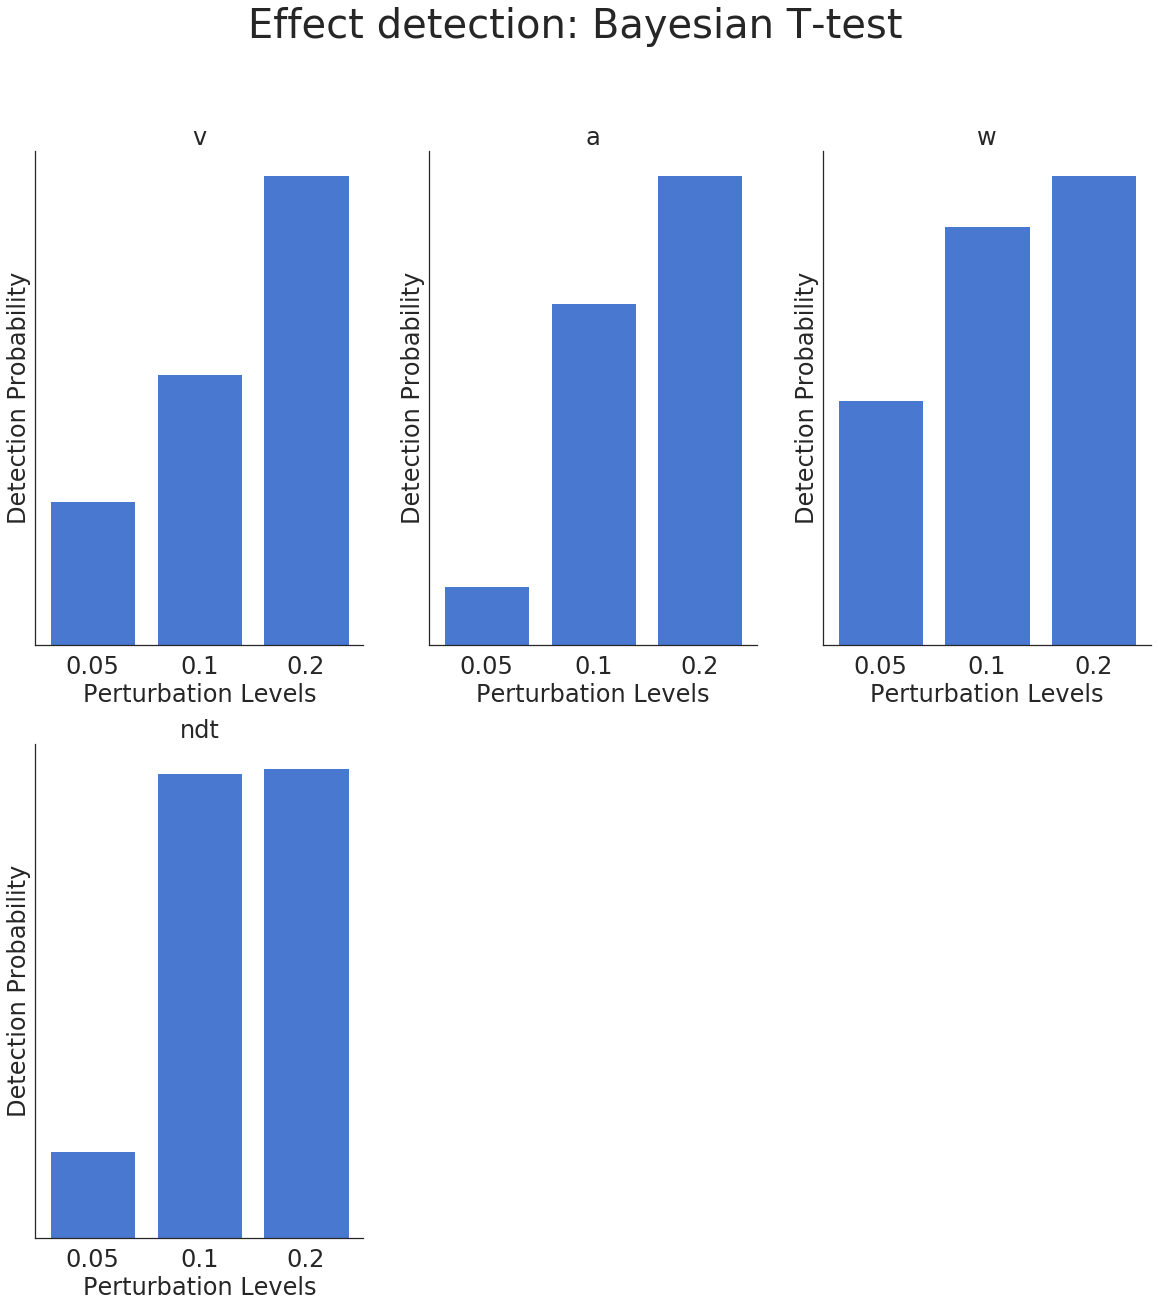

In [143]:
# n = 500
detection_rate_plots(data = detection_ratio_list[2])

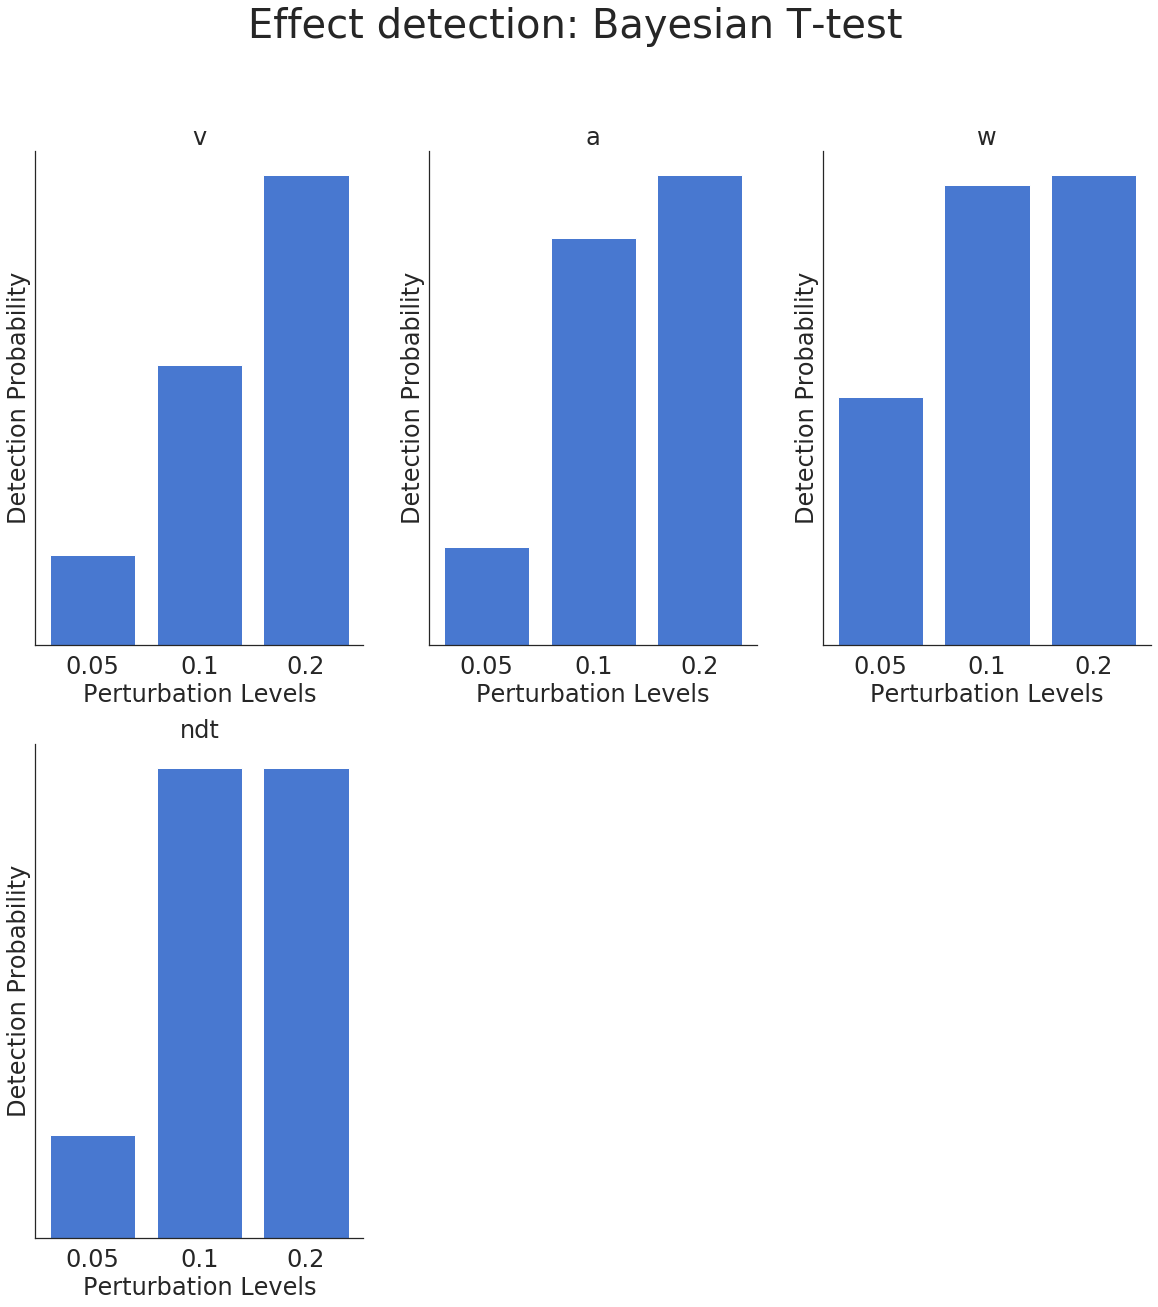

In [144]:
# n = 1000
detection_rate_plots(data = detection_ratio_list[3])

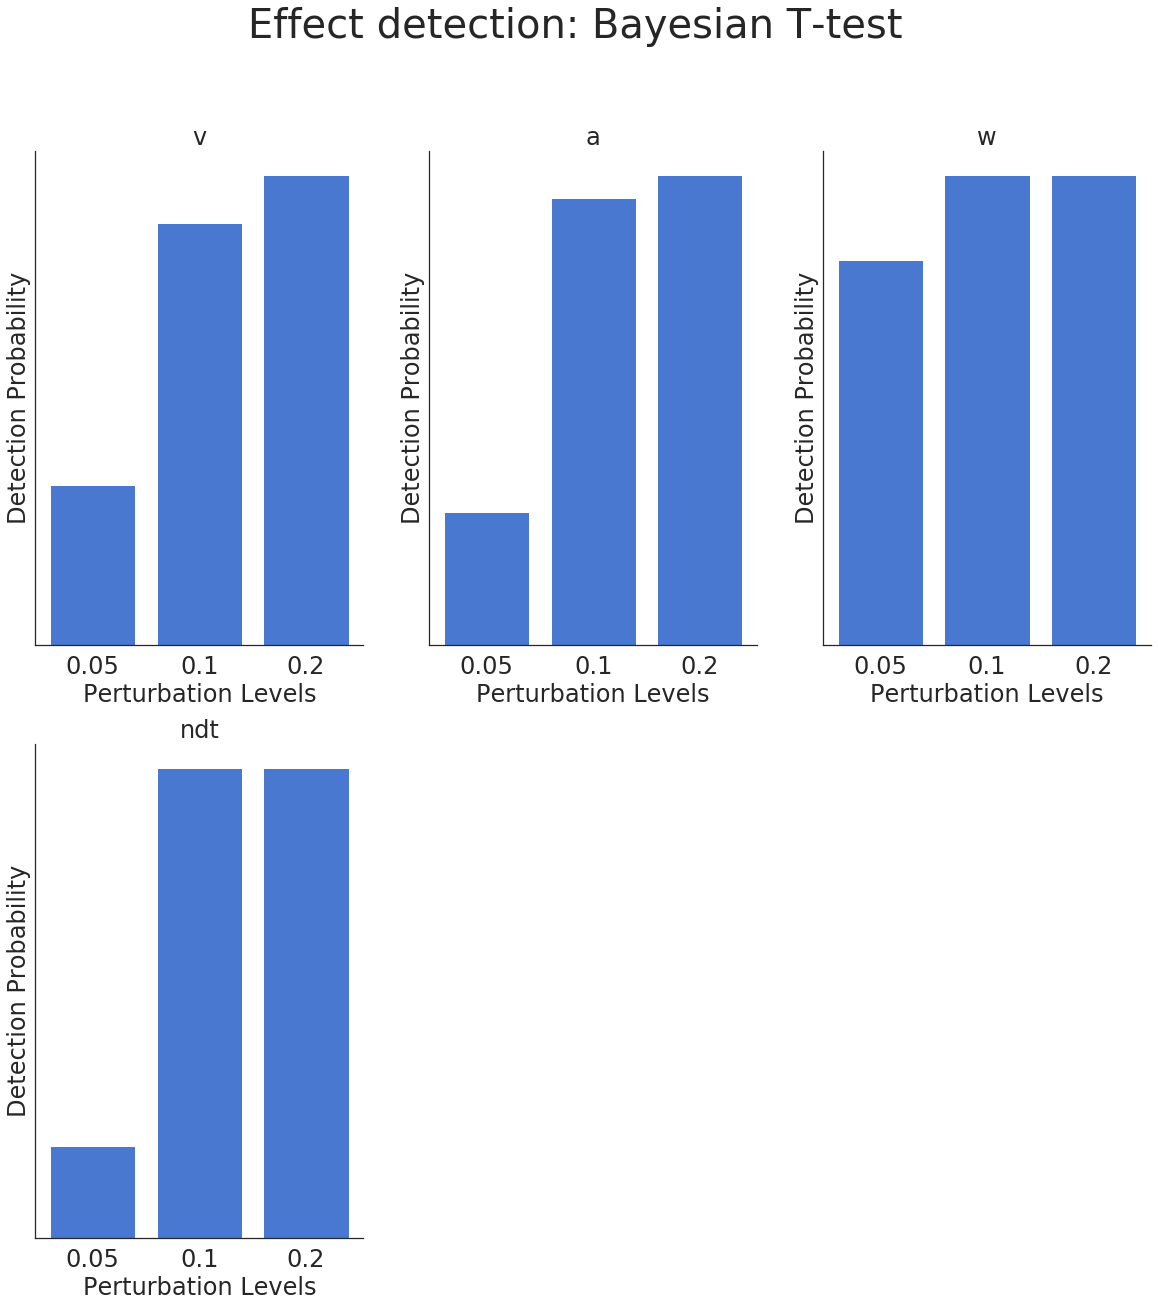

In [145]:
# n = 2000
detection_rate_plots(data = detection_ratio_list[4])

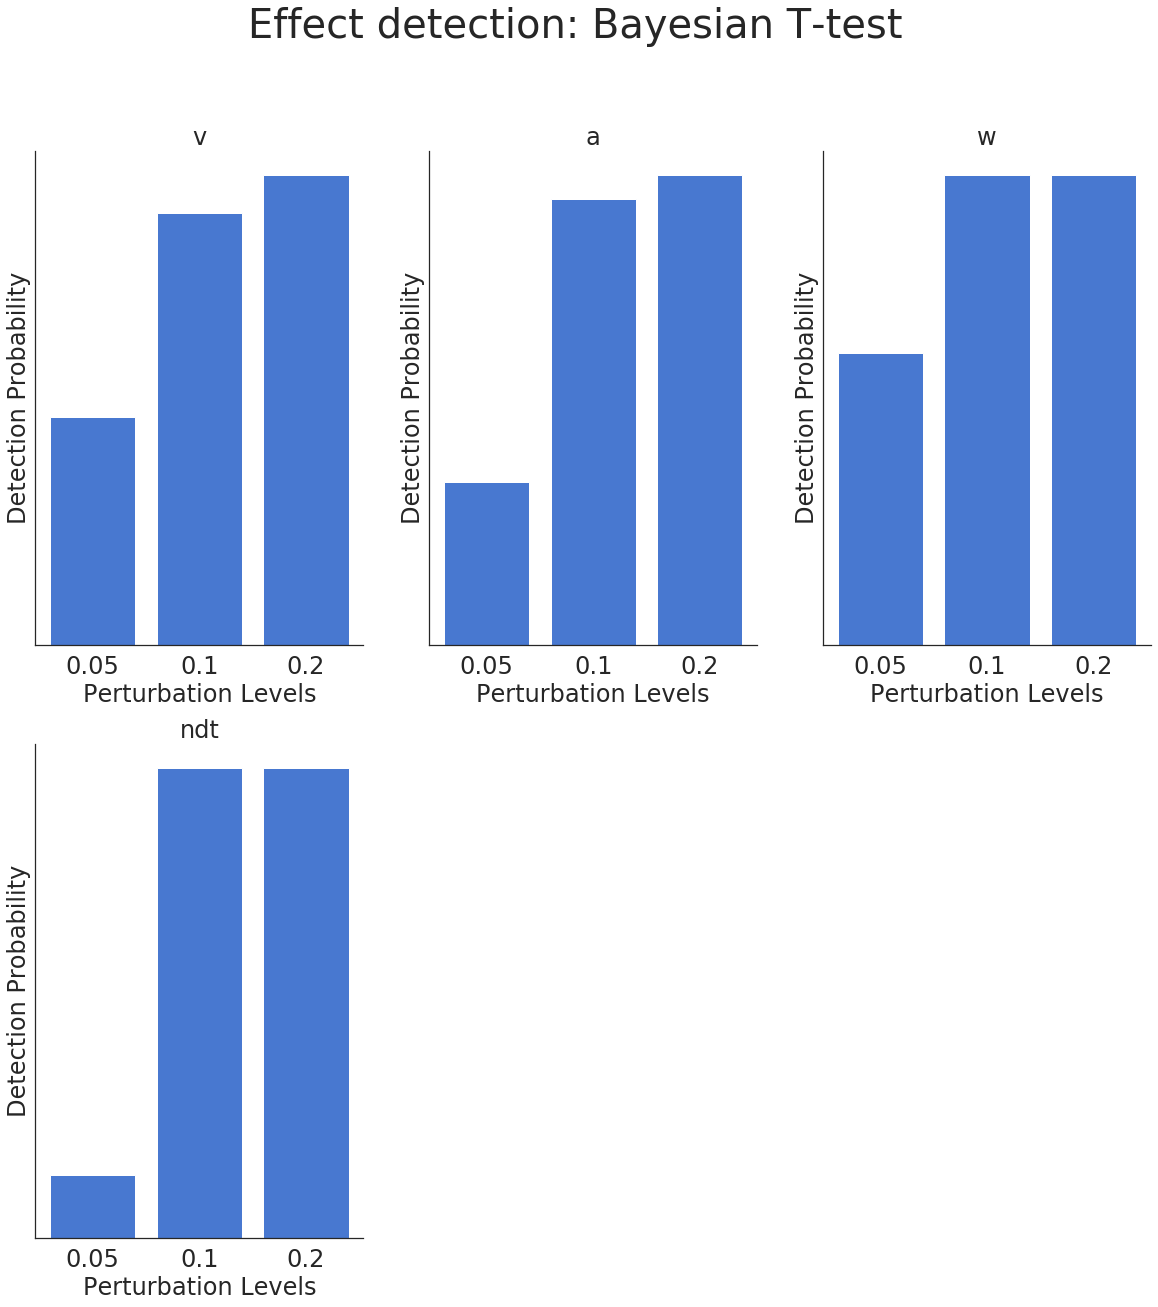

In [146]:
# n = 3000
detection_rate_plots(data = detection_ratio_list[5])

In [147]:
# FCN

# Initializations
sample_sizes = [100 , 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/kde/ddm/method_comparison/'
file_base_name = file_folder + 'deep_inference_perturbation_experiment_nexp_1_n_'
detection_ratio_list_fcn = []

# Load meta_data file (assumed to be same across all experiment datasets)
meta_data = pickle.load(open(glob.glob(file_folder + 'base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]

# Get detection ratios for all experiments
for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out = bayesian_t_test_global(file_list = files_,
                                 meta_data = meta_data,
                                 kind = 'fcn')
    
    detection_ratio_list_fcn.append(get_detection_ratios(out))

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_1.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_10.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_100.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_11.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_12.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_13.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_14.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_15.pickle
/media/data_cifs/afengler/data/kde/ddm/method_co

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_71.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_72.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_73.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_74.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_75.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_76.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_77.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_78.pickle
/media/data_cifs/afengler/data/kde/ddm/method_co

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_45.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_46.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_47.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_48.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_49.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_5.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_50.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_51.pickle
/media/data_cifs/afengler/data/kde/ddm/method_com

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_17.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_18.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_19.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_2.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_20.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_21.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_22.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_23.pickle
/media/data_cifs/afengler/data/kde/ddm/method_com

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_8.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_80.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_81.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_82.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_83.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_84.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_85.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_86.pickle
/media/data_cifs/afengler/data/kde/ddm/method_com

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_53.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_54.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_55.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_56.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_57.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_58.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_59.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_6.pickle
/media/data_cifs/afengler/data/kde/ddm/me

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_25.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_26.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_27.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_28.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_29.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_3.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_30.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_31.pickle
/media/data_cifs/afengler/data/kde/ddm/me

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_88.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_89.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_9.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_90.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_91.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_92.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_93.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_94.pickle
/media/data_cifs/afengler/data/kde/ddm/me

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_61.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_62.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_63.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_64.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_65.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_66.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_67.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_68.pickle
/media/data_cifs/afengler/data/kde/ddm/m

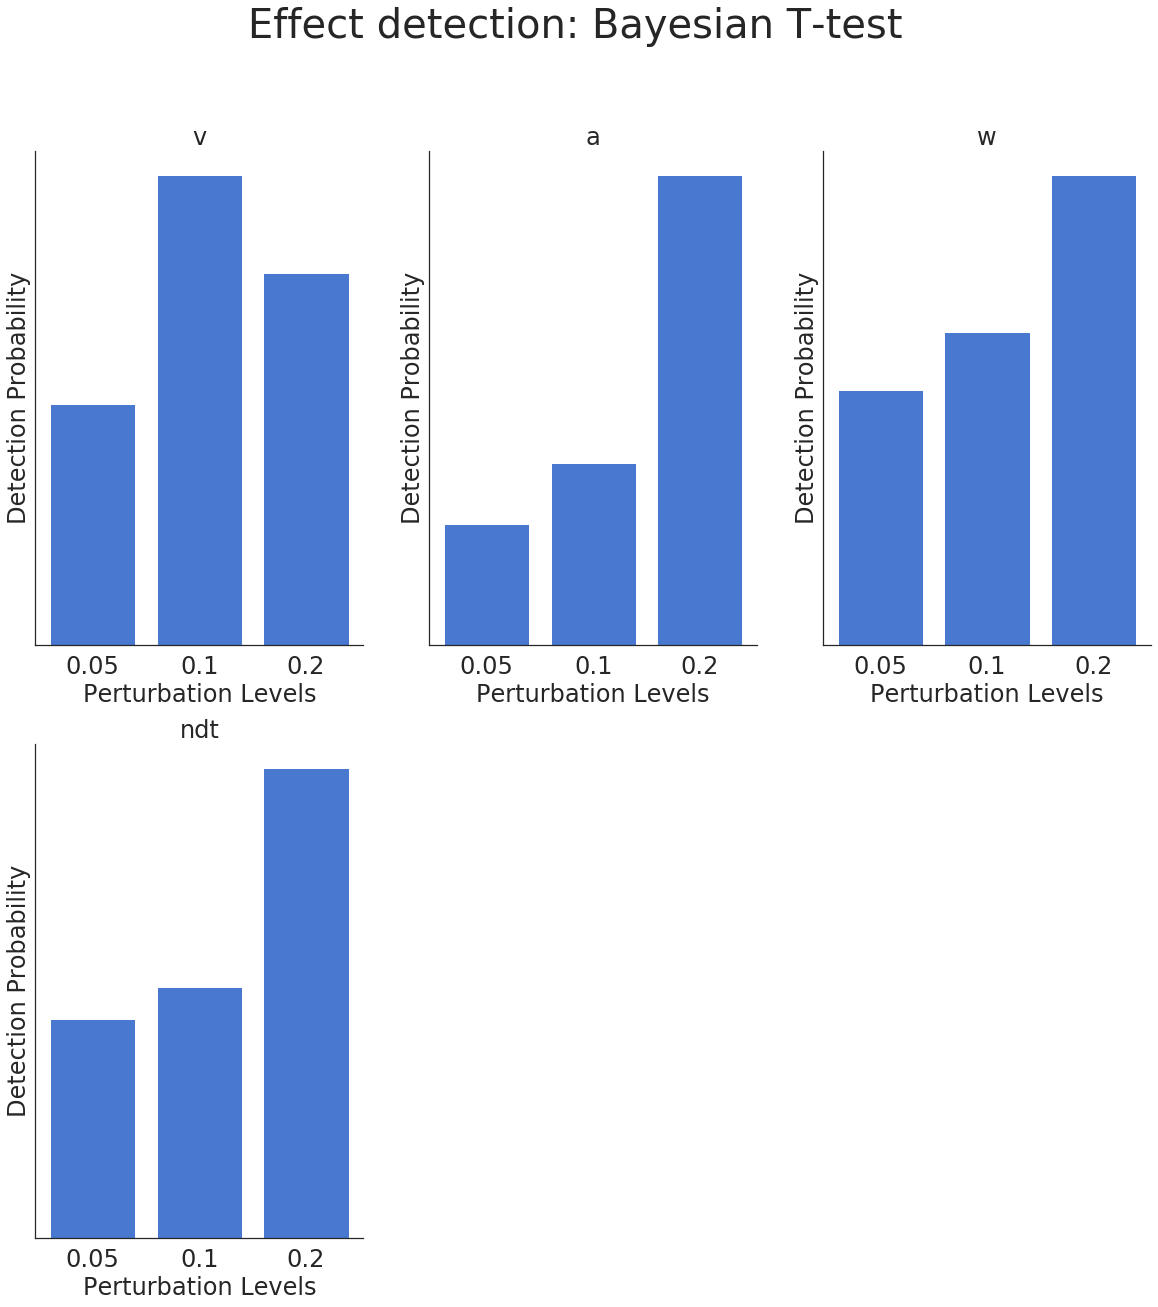

In [148]:
# n = 100
detection_rate_plots(data = detection_ratio_list_fcn[0])

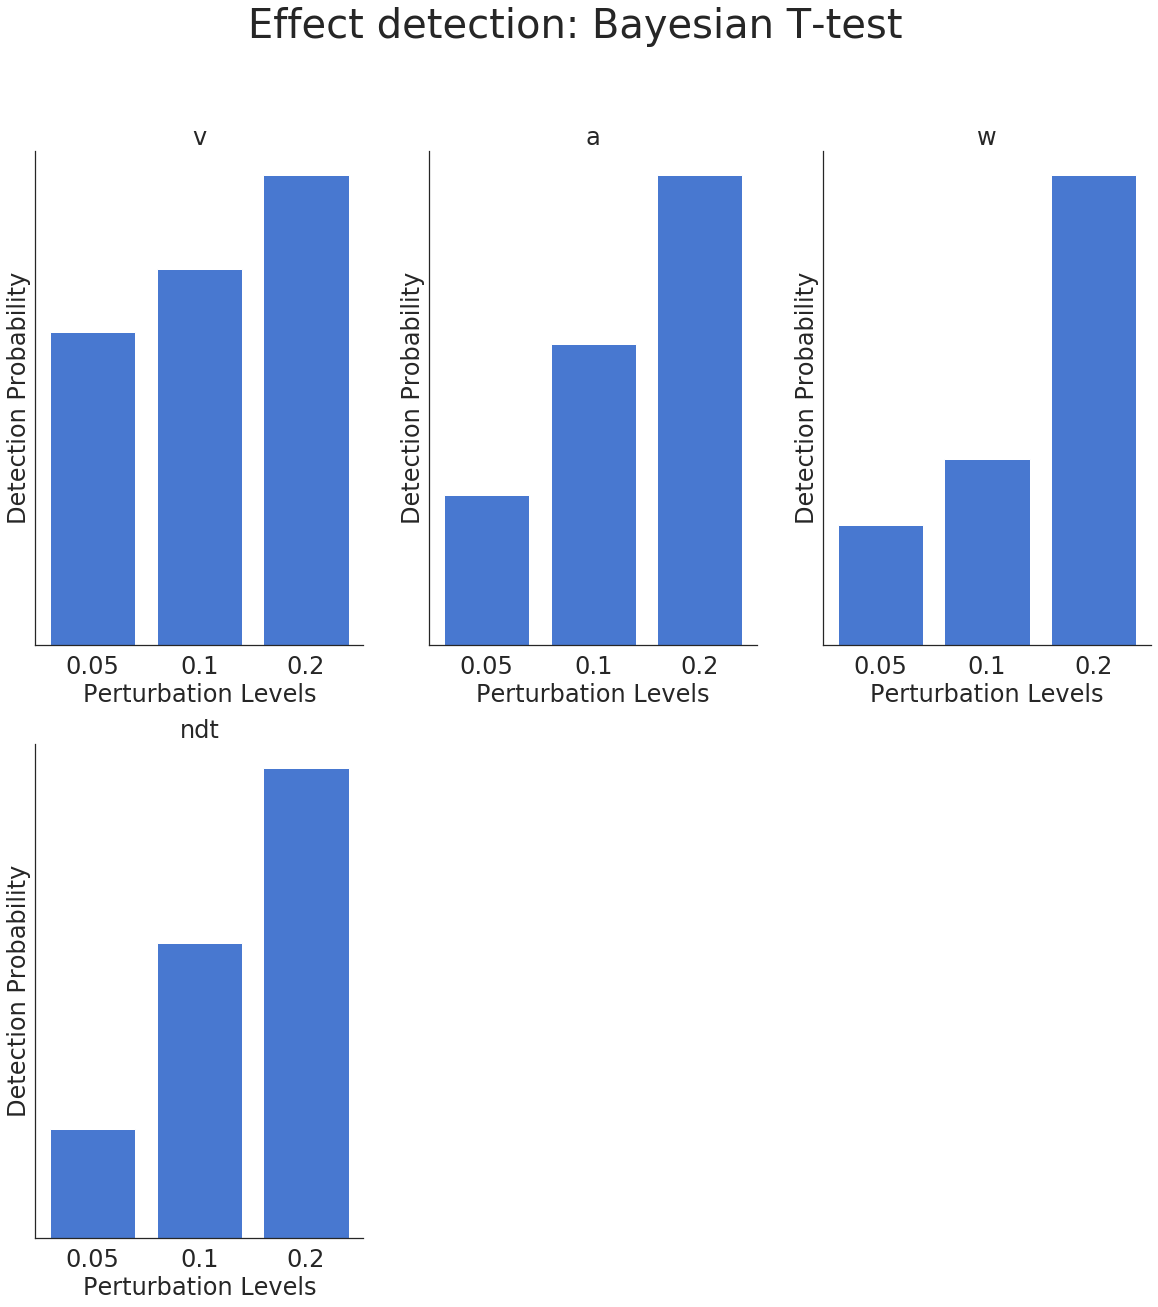

In [149]:
# n = 250
detection_rate_plots(data = detection_ratio_list_fcn[1])

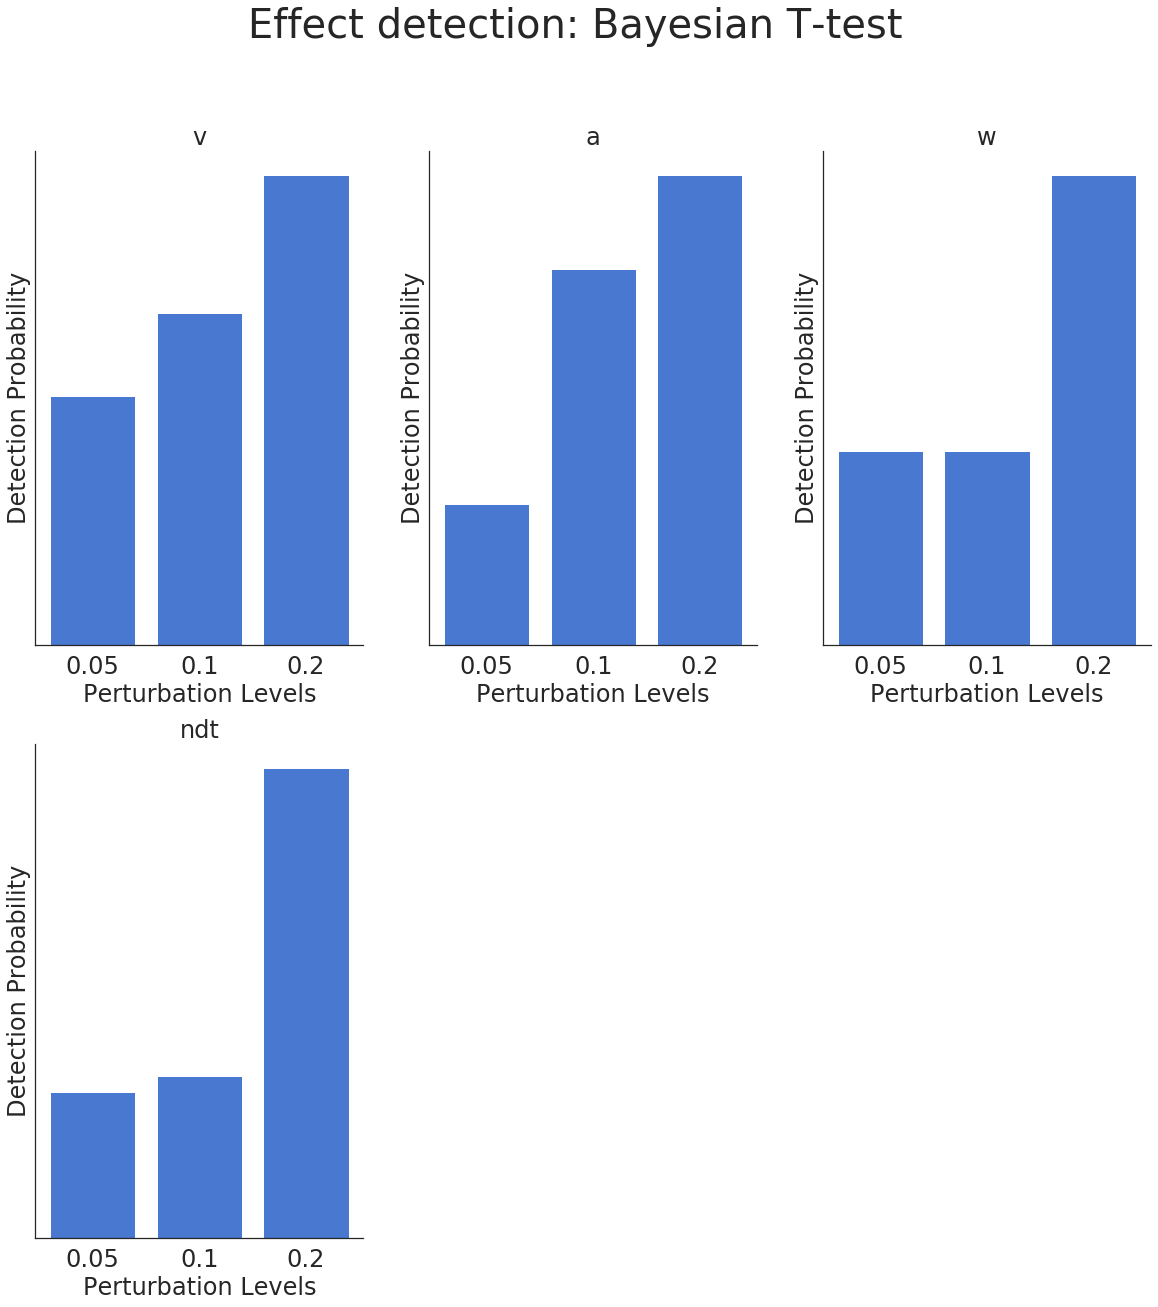

In [150]:
# n = 500
detection_rate_plots(data = detection_ratio_list_fcn[2])

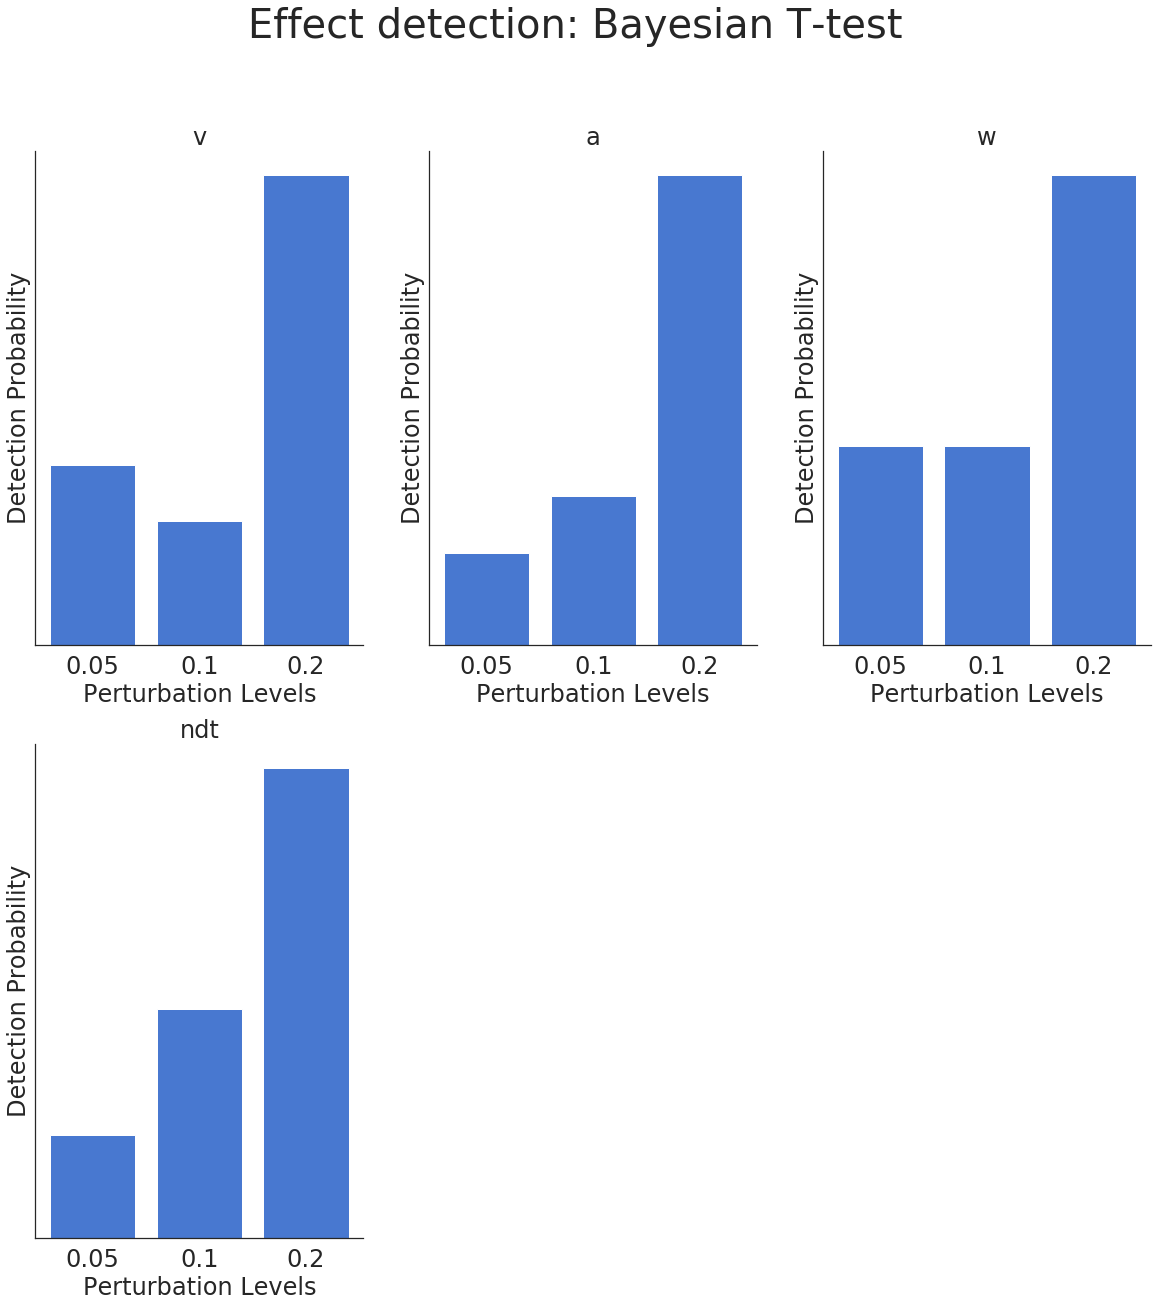

In [151]:
# n = 1000
detection_rate_plots(data = detection_ratio_list_fcn[3])

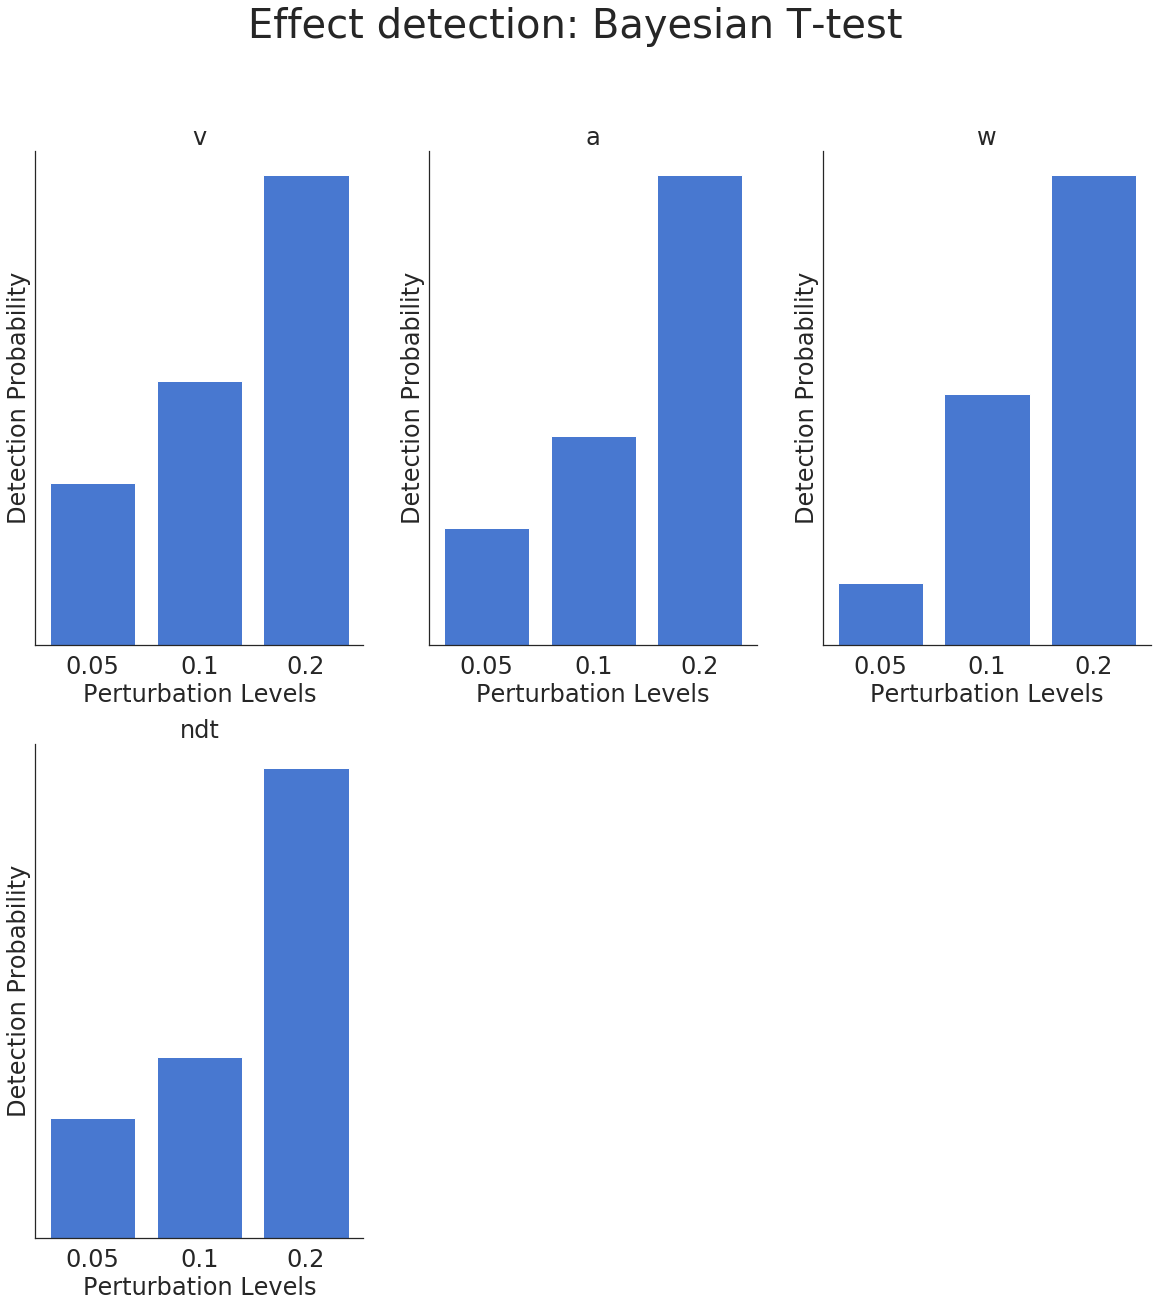

In [152]:
# n = 2000
detection_rate_plots(data = detection_ratio_list_fcn[4])

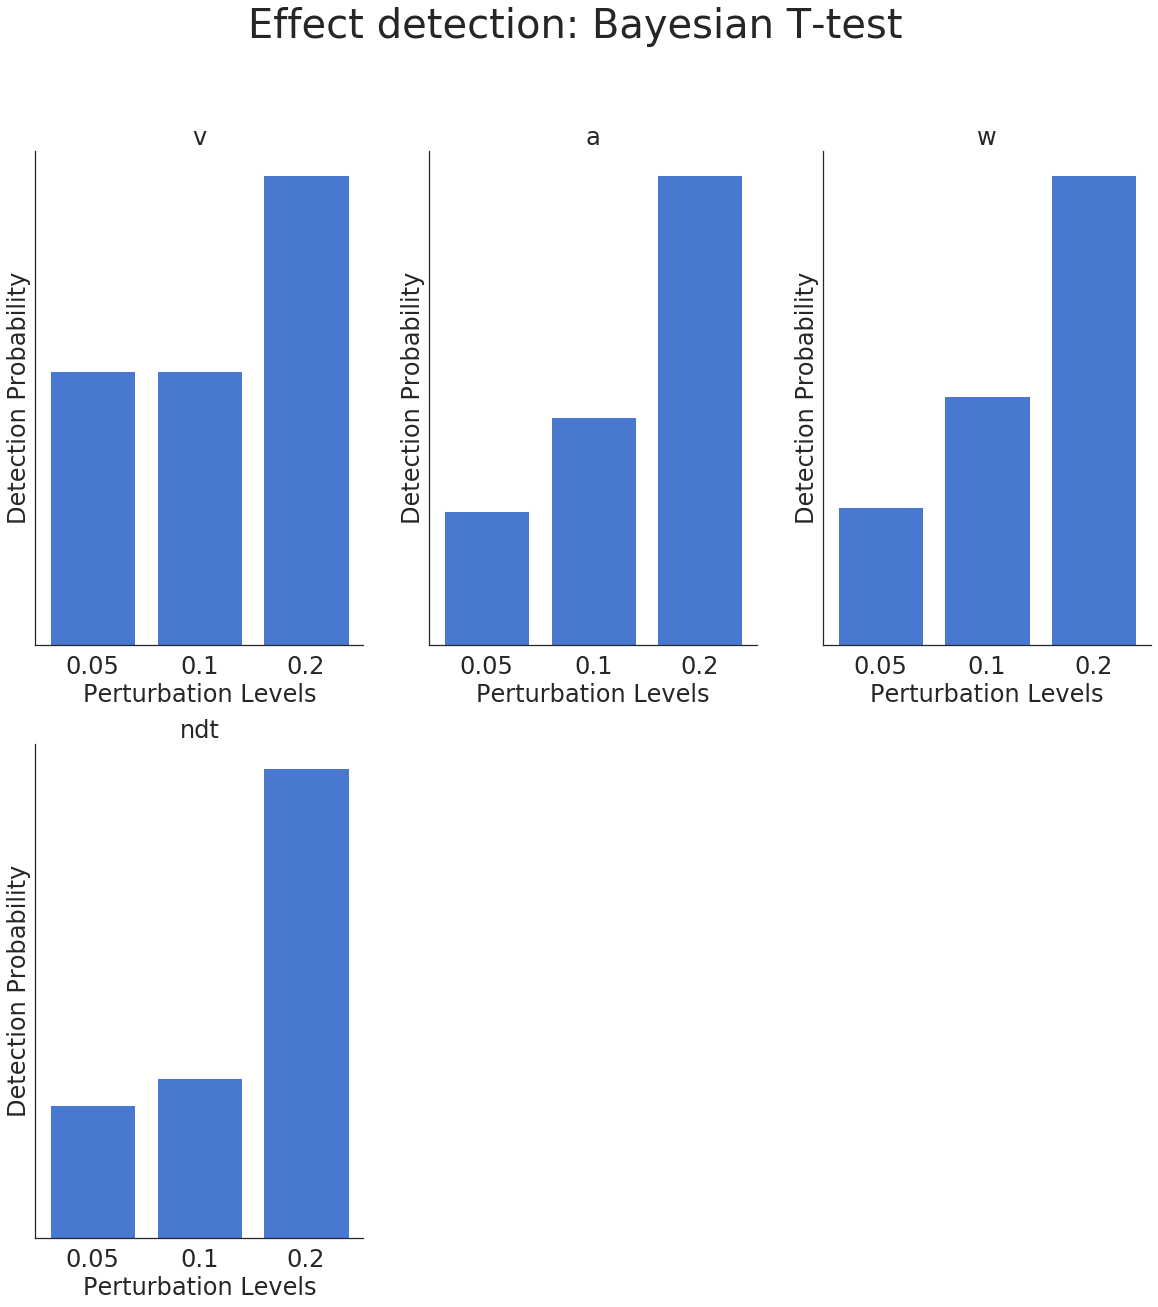

In [153]:
# n = 3000
detection_rate_plots(data = detection_ratio_list_fcn[5])

In [40]:
T = np.linspace(0, 10, 10000)

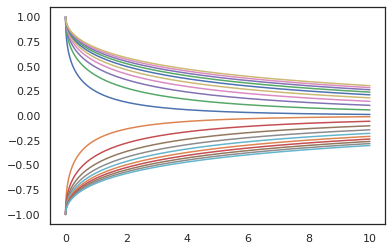

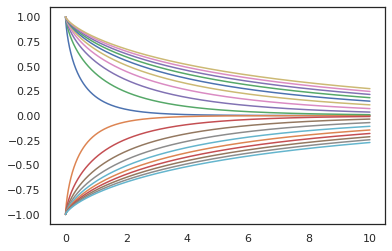

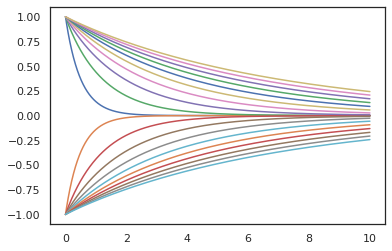

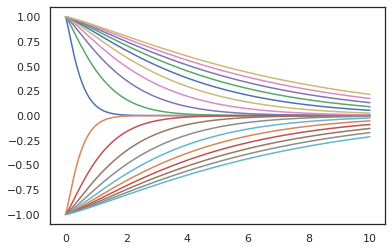

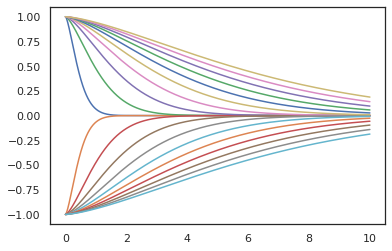

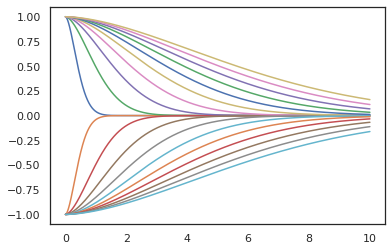

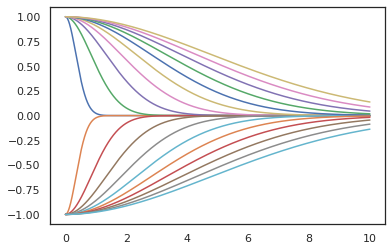

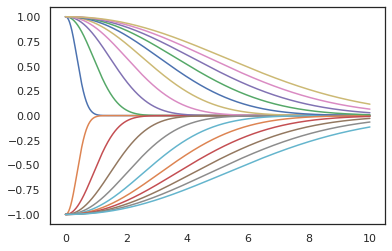

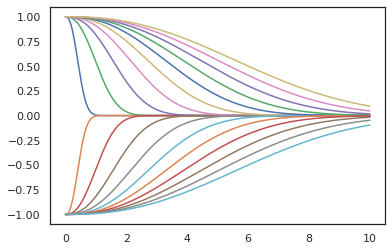

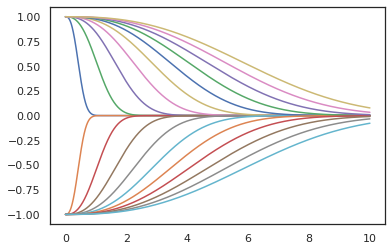

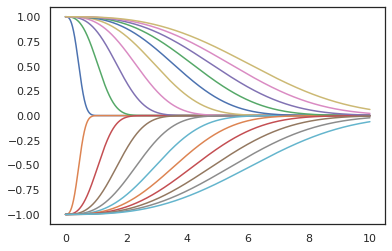

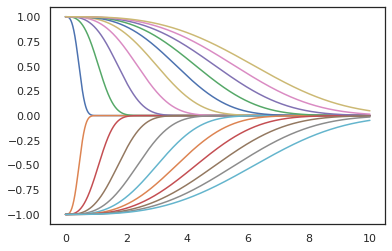

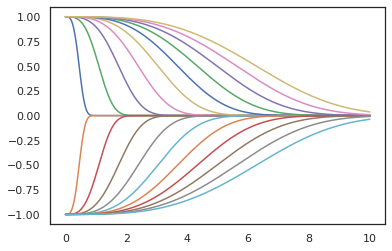

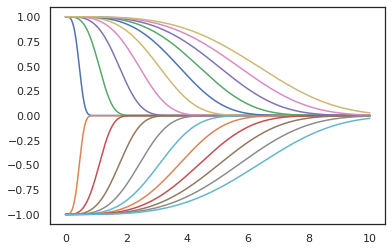

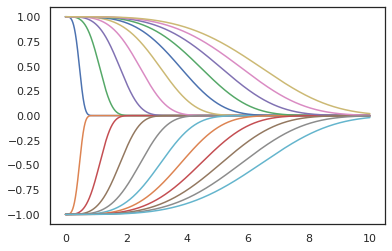

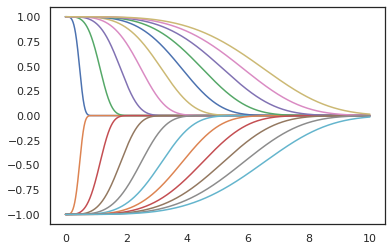

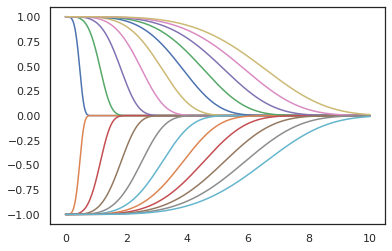

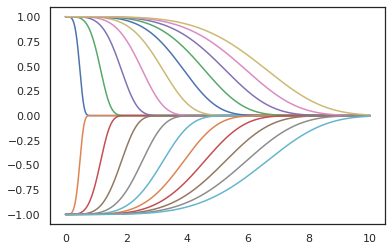

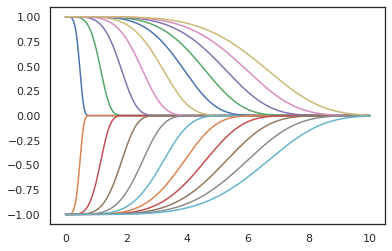

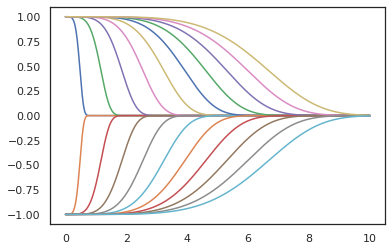

In [83]:
# Changing a
for i in np.linspace(0.5, 5, 20):
    for j in np.linspace(0.5, 7, 10):
        y = weibull_cdf(t = T,
                        a = i,
                        beta = j)
        plt.plot(T, y, T, -y)
    plt.show()

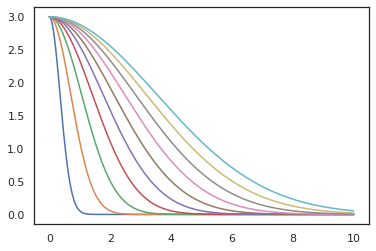

In [63]:
# Changing b
for i in np.linspace(0.5, 5, 10):
    y = 3 * weibull_cdf(t = T,
                        a = 2, 
                        beta = i)
    #plt.plot(T, y, T, -y)
    plt.plot(T, y)